In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# ---- 1. Model Definition (MMoE with Temperature Scaling) ----
class Expert(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, p_dropout=0.3):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(p_dropout)]
            prev = h
        layers.append(nn.Linear(prev, output_size))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class Tower(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p_dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x)

class MMoE(nn.Module):
    def __init__(self, input_size, num_experts, expert_hidden, expert_output_dim, tower_hidden_dim, task_output_dims, temperature=1.0):
        super().__init__()
        self.num_tasks = len(task_output_dims)
        self.temperature = nn.Parameter(torch.tensor(temperature), requires_grad=True)
        self.experts = nn.ModuleList(
            Expert(input_size, expert_hidden, expert_output_dim)
            for _ in range(num_experts)
        )
        self.gates = nn.ModuleList(
            nn.Linear(input_size, num_experts, bias=False)
            for _ in range(self.num_tasks)
        )
        self.towers = nn.ModuleList(
            Tower(expert_output_dim, tower_hidden_dim, out_dim)
            for out_dim in task_output_dims
        )
    def forward(self, x):
        expert_stack = torch.stack([expert(x) for expert in self.experts], dim=0)
        outputs = []
        for gate, tower in zip(self.gates, self.towers):
            weights = F.softmax(gate(x), dim=1)
            weighted = torch.einsum("be,ebd->bd", weights, expert_stack)
            y = tower(weighted)
            # Temperature scaling for calibration
            y = y / self.temperature
            outputs.append(y)
        return outputs

In [13]:

# ---- 2. Data Loading ----
col_list = [
    "age", "gender", "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", "triage_temperature", "triage_heartrate", "triage_resprate", "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity", "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", "chiefcom_dizziness", "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", "cci_HIV", "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"
]
outcome_list = [
    "outcome_hospitalization", "outcome_critical", "outcome_ed_revisit_3d", "outcome_sepsis", "outcome_pneumonia_bacterial", "outcome_pneumonia_viral", "outcome_pneumonia_all", "outcome_ards", "outcome_pe", "outcome_copd_exac", "outcome_acs_mi", "outcome_stroke", "outcome_aki"
]

df = pd.read_csv("../data/train_with_outcomes.csv")
df_test = pd.read_csv("../data/test_with_outcomes.csv")
raw_feats = df.loc[:, col_list]
feat_df = raw_feats.select_dtypes(include=[np.number, bool])
feat_df = feat_df.fillna(feat_df.mean())
X_np = feat_df.to_numpy(dtype=float)
y_np = df.loc[:, outcome_list].to_numpy(dtype=float)

X_t = torch.from_numpy(X_np).float()
y_t = torch.from_numpy(y_np).float()
dataset = TensorDataset(X_t, y_t)

# 80/10/10 split
n_total  = len(dataset)
n_train  = int(0.8 * n_total)
n_val    = int(0.1 * n_total)
n_test   = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))
batch_size = 256
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [14]:

# ---- 3. Training & Validation ----
input_size = X_np.shape[1]
num_experts = 8
expert_hidden = [128, 64]
expert_output_dim = 32
tower_hidden_dim = 16
task_output_dims = [1] * len(outcome_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MMoE(input_size, num_experts, expert_hidden, expert_output_dim, tower_hidden_dim, task_output_dims, temperature=1.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterions = [nn.BCEWithLogitsLoss() for _ in range(len(outcome_list))]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

def run_epoch(dl, phase="train"):
    is_train = phase == "train"
    model.train() if is_train else model.eval()
    epoch_loss = 0.
    running_preds, running_trues = [ [] for _ in range(len(outcome_list)) ], [ [] for _ in range(len(outcome_list)) ]
    for X_batch, y_batch in dl:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.set_grad_enabled(is_train):
            outputs = model(X_batch)
            losses  = [crit(o.squeeze(), y_batch[:, i]) for i, (o, crit) in enumerate(zip(outputs, criterions))]
            loss = torch.stack(losses).mean()
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
                optimizer.step()
        epoch_loss += loss.item() * len(X_batch)
        for i, o in enumerate(outputs):
            running_preds[i].append(o.detach().cpu())
            running_trues[i].append(y_batch[:, i].cpu())
    aucs = []
    for preds, trues in zip(running_preds, running_trues):
        preds = torch.cat(preds).numpy()
        trues = torch.cat(trues).numpy()
        try:
            aucs.append(roc_auc_score(trues, preds))
        except ValueError:
            aucs.append(float("nan"))
    return epoch_loss / len(dl.dataset), aucs

num_epochs = 10
best_val_auc = -float("inf")
for epoch in range(1, num_epochs + 1):
    train_loss, train_auc = run_epoch(train_dl, "train")
    val_loss,   val_auc   = run_epoch(val_dl,   "val")
    mean_val_auc = float(torch.tensor(val_auc).nanmean())
    scheduler.step(mean_val_auc)
    print(f"Epoch {epoch:02d} | Train loss {train_loss:.4f} | Val loss {val_loss:.4f} | Mean Val AUC {mean_val_auc:.4f}")
    if mean_val_auc > best_val_auc:
        best_val_auc = mean_val_auc
        torch.save(model.state_dict(), "best_mmoe.pt")


Epoch 01 | Train loss 0.1469 | Val loss 0.1256 | Mean Val AUC 0.7971
Epoch 02 | Train loss 0.1306 | Val loss 0.1192 | Mean Val AUC 0.8154
Epoch 03 | Train loss 0.1252 | Val loss 0.1205 | Mean Val AUC 0.8242
Epoch 04 | Train loss 0.1232 | Val loss 0.1205 | Mean Val AUC 0.8228
Epoch 05 | Train loss 0.1220 | Val loss 0.1176 | Mean Val AUC 0.8248
Epoch 06 | Train loss 0.1205 | Val loss 0.1158 | Mean Val AUC 0.8330
Epoch 07 | Train loss 0.1199 | Val loss 0.1155 | Mean Val AUC 0.8316
Epoch 08 | Train loss 0.1196 | Val loss 0.1154 | Mean Val AUC 0.8344
Epoch 09 | Train loss 0.1195 | Val loss 0.1159 | Mean Val AUC 0.8354
Epoch 10 | Train loss 0.1185 | Val loss 0.1144 | Mean Val AUC 0.8376



=== Test metrics ===
Task outcome_hospitalization: AUC = 0.8140
Task outcome_critical: AUC = 0.8746
Task outcome_ed_revisit_3d: AUC = 0.7026
Task outcome_sepsis: AUC = 0.8934
Task outcome_pneumonia_bacterial: AUC = 0.8538
Task outcome_pneumonia_viral: AUC = 0.7881
Task outcome_pneumonia_all: AUC = 0.8022
Task outcome_ards: AUC = 0.8407
Task outcome_pe: AUC = 0.7773
Task outcome_copd_exac: AUC = 0.9349
Task outcome_acs_mi: AUC = 0.8880
Task outcome_stroke: AUC = 0.8649
Task outcome_aki: AUC = 0.8378
Average AUC (ignoring NaNs): 0.8363


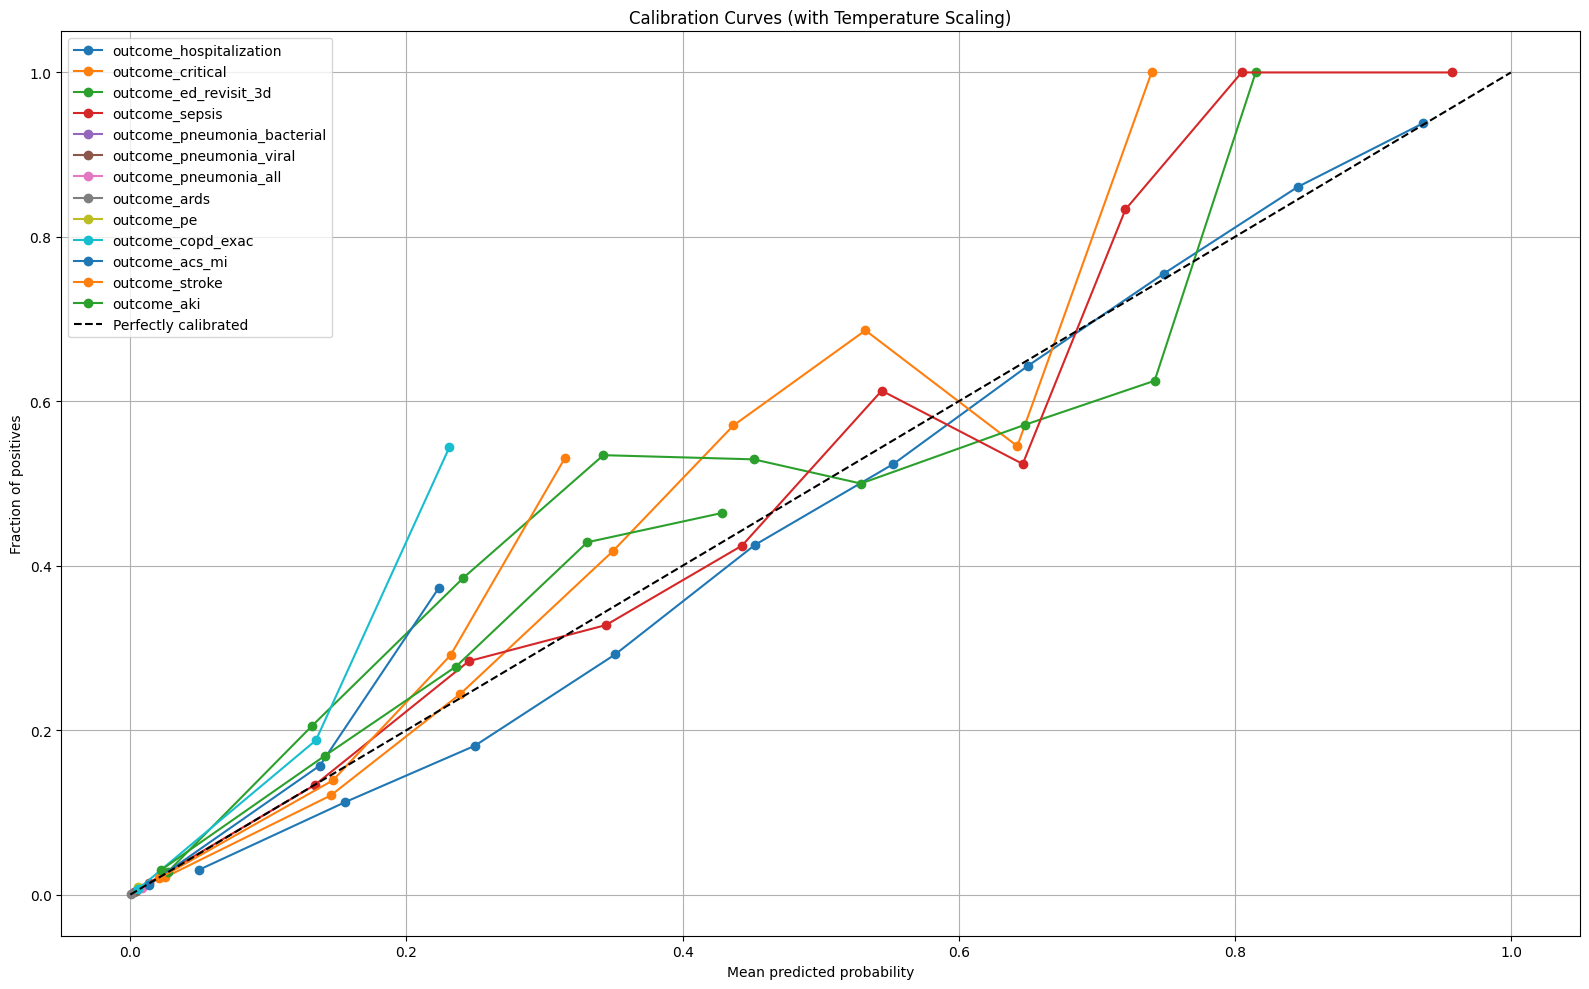

In [15]:

# ---- 4. Test & Calibration Curve ----
model.load_state_dict(torch.load("best_mmoe.pt"))
test_loss, test_auc = run_epoch(test_dl, "test")
print("\n=== Test metrics ===")
for i, auc in enumerate(test_auc):
    print(f"Task {outcome_list[i]}: AUC = {auc:.4f}")
print(f"Average AUC (ignoring NaNs): {torch.tensor(test_auc).nanmean():.4f}")

# Calibration curve
model.eval()
all_probs = []
all_trues = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits_list = model(xb)
        probs = [torch.sigmoid(logits.cpu()).numpy().squeeze() for logits in logits_list]
        all_probs.append(np.stack(probs, axis=1))
        all_trues.append(yb.numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_trues = np.concatenate(all_trues, axis=0)

plt.figure(figsize=(16, 10))
for i, task in enumerate(outcome_list):
    prob_true, prob_pred = calibration_curve(all_trues[:, i], all_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=task)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves (with Temperature Scaling)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

